In [29]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import matplotlib.pyplot as plt
from scarlet2 import *
import optax
from tqdm.auto import tqdm
import pandas as pd

In [31]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #
# use 14090 great examle
# 15290 ok

data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
data = df[df['parent_ID']==df['parent_ID'][14090]] # select one randome scene 15100 is cool
#data = df[df['parent_ID']==df['parent_ID'][15100]] # select one randome scene 15100 is cool
#data = pd.read_pickle('mock_galaxy_src_6.pkl')
# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
# multi_filters = np.array([np.array(data['mask_g'])[0] , np.array(data['mask_r'])[0]  , np.array(data['mask_i'])[0]  , 
#                         np.array(data['mask_y'])[0]  , np.array(data['mask_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

images = multi_images 
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )

# for galsim storage
#box_size = jnp.asarray( data["box_sz"][0] )
#centers  = jnp.asarray( [(src) for src in data["loc"][0]] )

weights = 1/multi_var 
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)
obs.match(model_frame);
morph_init_scarlet = np.array([i for i in data['scar_g'] ])
print('----------------------------------------')
print(f"    Scene contains {len(centers)} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 6 galaxy sources
----------------------------------------


/var/folders/hq/wy849_h10qlbj1pf5_gxyh9m0000gn/T/ipykernel_52389/696415957.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  morph_init_scarlet = np.array([i for i in data['scar_g'] ])


In [32]:
# define initial circular model for initial morphology estimate 
from skimage import draw

# empty list
morph_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .25 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/15, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (box_size[i], box_size[i]))
    raw =  (jnp.array(arr) + sigma * noise)
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))
    morph_init[i] = normed
    
# plt.imshow(morph_init[0])

In [33]:
# try to mess around getting prior to work
# TODO: determine best way to ensure prior is being used

keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene:
    for i in range(len( centers )):
        Source(
            centers[i],
            ArraySpectrum(random.normal(keys[0], (5,)), constraint=PositiveConstraint()),
            #ArrayMorphology(morph_init[i], prior=NNPrior())
            ArrayMorphology(morph_init_scarlet[i], prior=NNPrior())
        )

In [34]:
# TODO: fix "jax.tree_structure" is deprecated so we can use latest jax and equinox
# TODO: fix the non-hashable item in Observation class so we can use jit
src_num = len( centers )
weight = 1

# ------------------ #
# tracking functions #
# ------------------ #
@eqx.filter_value_and_grad
def lik_grad(model, obs, weight):
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    return  neg_log_like

@eqx.filter_value_and_grad
def neural_grad(model, obs, weight):
    prior = 0.0
    sources = model()
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  -prior 

def track_grad(model, obs, weigth):
    loss1, grad_lik    = lik_grad(model, obs, weigth)
    loss1, grad_neural = neural_grad(model, obs, weigth)
    return grad_lik, grad_neural

# ------------------ #
# main train routine #
# ------------------ #
@eqx.filter_value_and_grad
def loss_fn_with_grad(model, obs, weight):
    prior = 0.0
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  neg_log_like - prior  

#@eqx.filter_jit
# TODO: Hash error when using jit in the Observation class -- think I need to convert tuple to list?
def make_step(model, obs, opt_state, weigth):
    loss, grads = loss_fn_with_grad(model, obs, weigth)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, grads, model, opt_state


learning_rate= 3e-1 # alter this
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(scene, eqx.is_array))
best_loss = 1e20
iters = 250
loss_vec = []
factor_vec = []
grad_factor = jnp.linspace(5,20, iters)

pbar = tqdm(range(iters), desc='fitting sources')
for step in pbar:
    loss, grads, scene, opt_state = make_step(scene, obs, opt_state, weight)
    loss = loss.item()
    #weight = grad_factor[step]
    weight = 20
    loss_vec.append(loss)
    factor_vec.append(weight)
    pbar.set_description(f" fitting sources ==>  step: {step} loss: {loss}")
        
    # track gradient evolution
    if step == iters -2:
        grad_lik, grad_neural = track_grad(scene, obs, weight)
        
print(f"final step={step} loss={loss}")

fitting sources:   0%|          | 0/250 [00:00<?, ?it/s]

final step=249 loss=74885.9921875


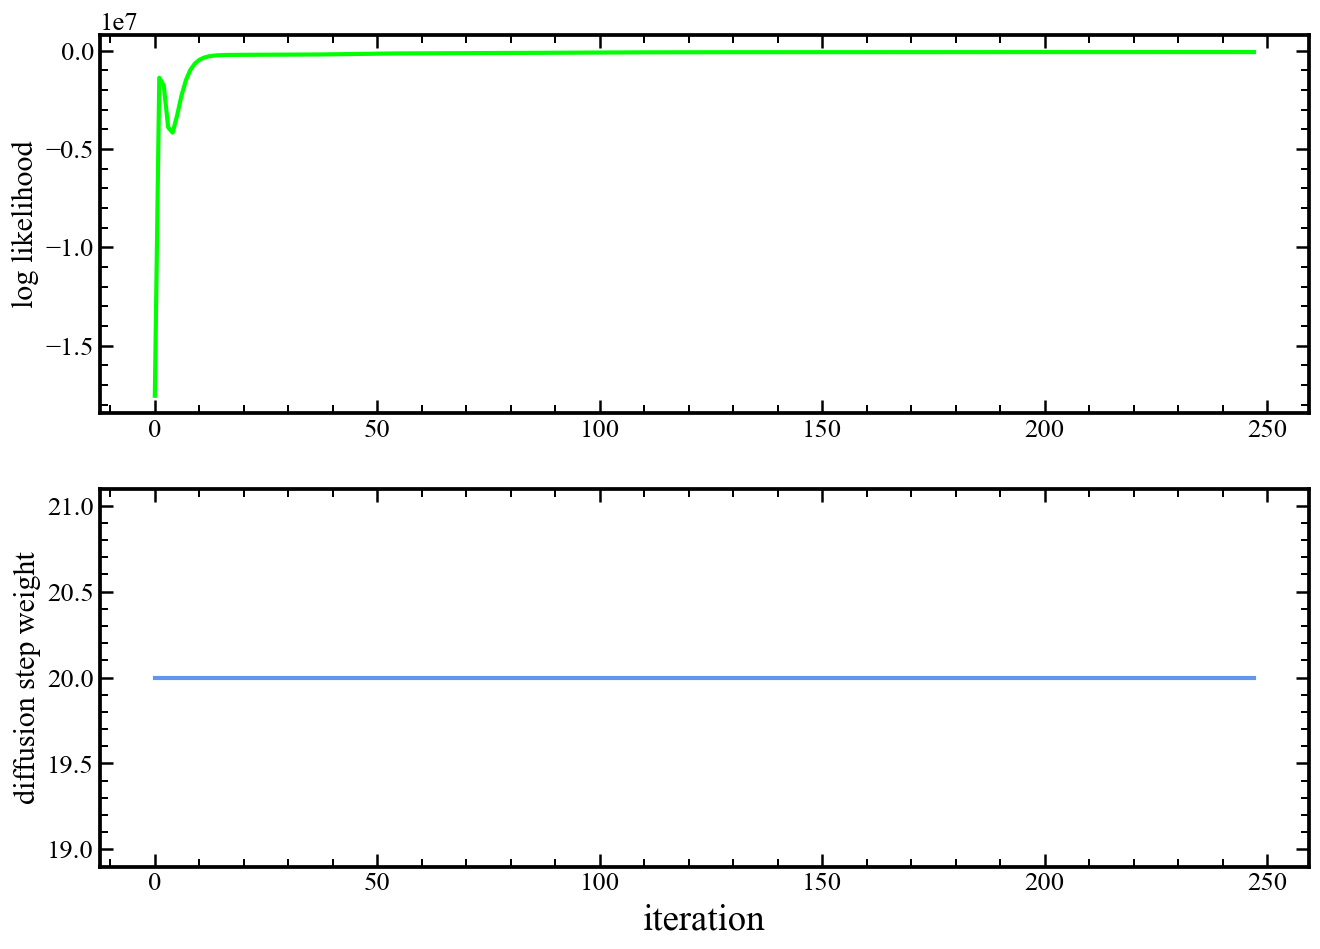

In [35]:
fig = plt.figure(figsize=(13, 9), dpi = 120)
plt.subplot(2,1,1)
plt.plot(-1 * np.array(loss_vec[1:-1]), color='lime')
plt.ylabel("log likelihood", fontsize=18)
plt.subplot(2,1,2)
plt.plot(factor_vec[1:-1], color = 'cornflowerblue')
plt.xlabel('iteration', fontsize=22)
plt.ylabel('diffusion step weight', fontsize=18)
plt.show()

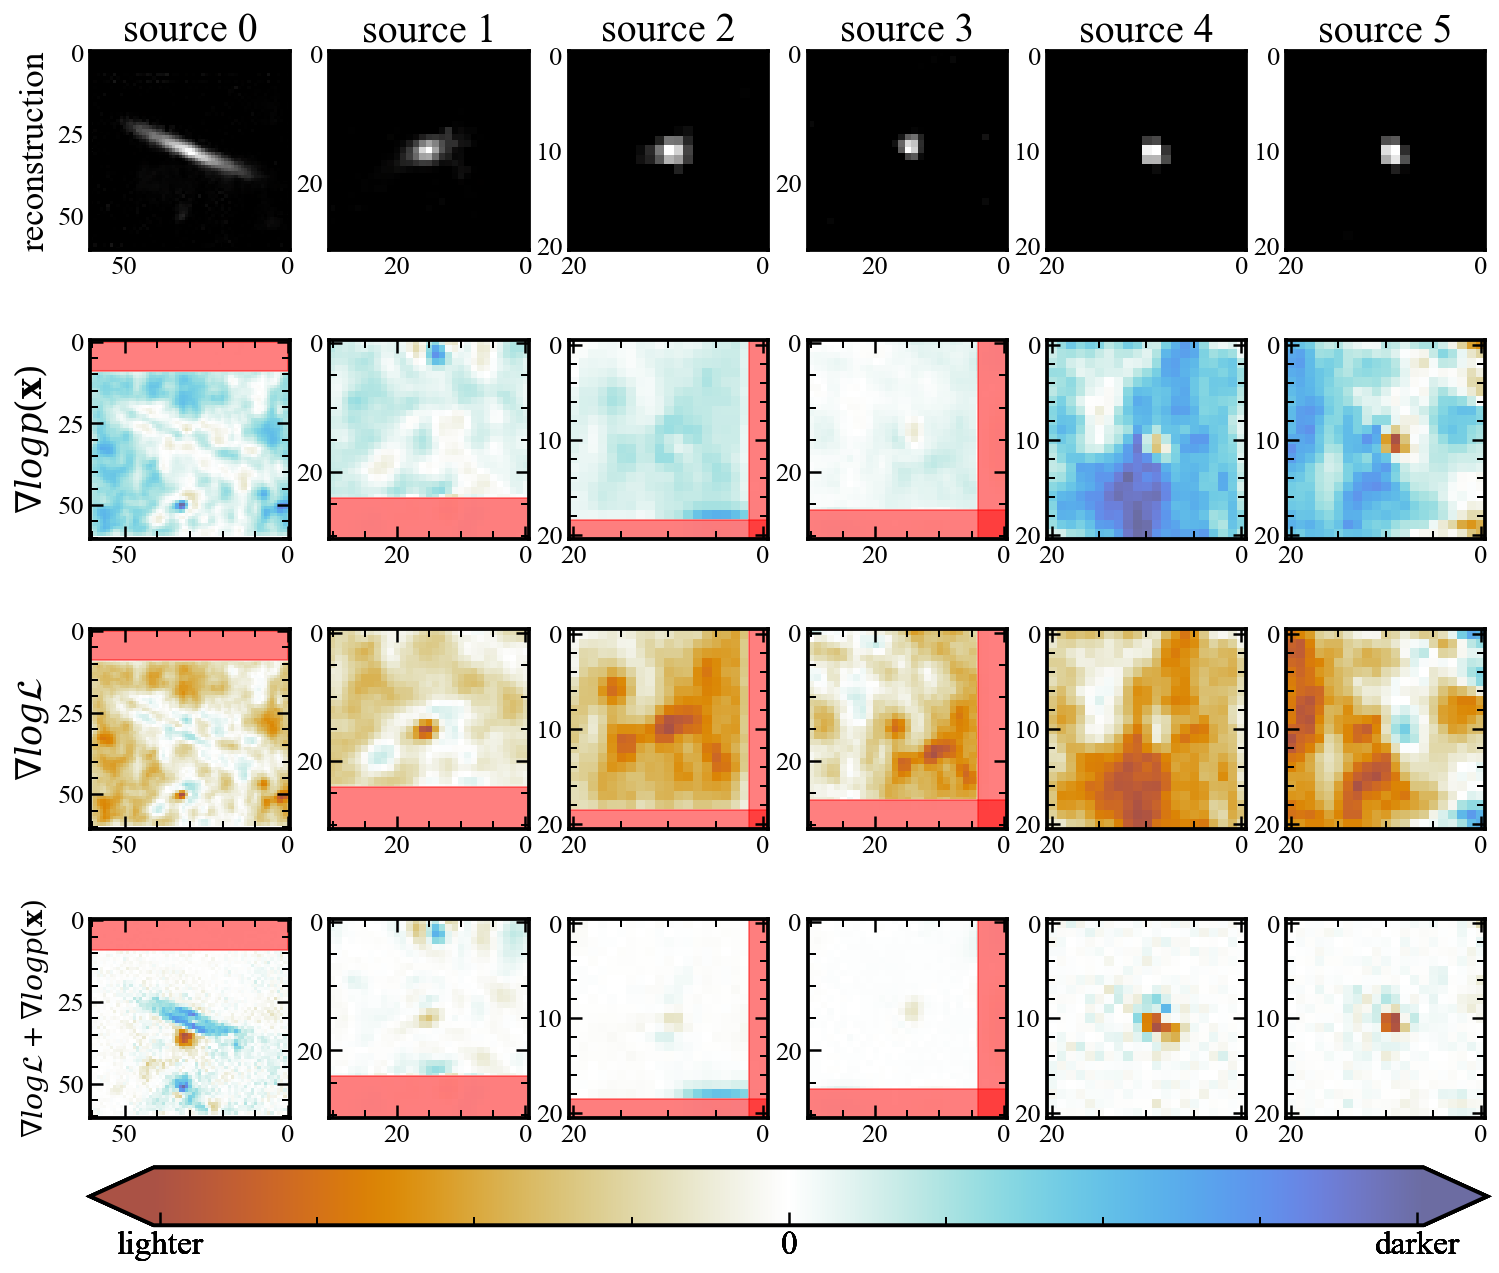

In [36]:
# test to see if issue is with image storage type
# NOTE: nope works fine. grads correctly calculated, but not with the log_prior routine
import jax
import cmasher as cmr
int_method = 'none'
cmap = cmr.prinsenvlag
cbar = False
from matplotlib.patches import Rectangle

from jax import jvp
def hvp(f, primals, tangents):
    return jvp(f, primals, tangents)[1]

renders = obs.render(scene())
fig = plt.figure(figsize=(15, 12), dpi = 120)
num_src = len( scene.sources )
for idx in range(num_src):
    grad_nn    = grad_neural.sources[idx].morphology.value
    grad_nll   = grad_lik.sources[idx].morphology.value
    grad_sum   = grad_nn + grad_nll
    grad_used  = grads.sources[idx].morphology.value
    morphology = scene.sources[idx].morphology.value
    # observation model plus rendered
    #morphology = renders[idx]
    
    

    # source morphology
    plt.subplot(4, num_src, idx + 1)
    plt.imshow(morphology,cmap = cmr.neutral, vmin = 0,interpolation=int_method)
    ax = plt.gca()
    ax.invert_xaxis()
    plt.title(f"source {idx}", fontsize = 24)
    if idx==0:
        plt.ylabel("reconstruction", fontsize = 21)

        
    # nn grads
    plt.subplot(4, num_src, idx + 1 * num_src + 1)
    #plt.gca().invert_yaxis()
    tmax = np.max(np.abs(grad_nn))
    plt.imshow(grad_nn,cmap = cmap, vmin = -tmax, vmax = tmax, interpolation=int_method)
    if idx==0:
        plt.ylabel(r"$\nabla log p(\mathbf{x})$", fontsize = 21)
    # Create a Rectangle patch for padded regions
    ax = plt.gca()
    ax.invert_xaxis()
    if (idx==0): 
        rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect)
        rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect)
    if (idx==1): 
        rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect)       
        rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect)       
    if (idx==2): 
        rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect2)
        rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect2)
    if (idx==3): 
        rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect2)
        rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect2)
    
    # residual
    plt.subplot(4, num_src, idx + 2 * num_src + 1)
    #plt.gca().invert_yaxis()
    tmax = np.max(np.abs(grad_nll))
    plt.imshow(grad_nll,cmap = cmap, vmin = -tmax, vmax = tmax, interpolation=int_method)
    ax = plt.gca()
    ax.invert_xaxis()
    if (idx==0): 
        rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect)
        rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect)
    if (idx==1): 
        rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect)       
        rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect)       
    if (idx==2): 
        rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect2)
        rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect2)
    if (idx==3): 
        rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect2)
        rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect2)
        
        
    if idx==0:
        plt.ylabel(r"$\nabla log \mathcal{L}$", fontsize = 21)
     
    # used grads
    plt.subplot(4,num_src, idx + 3 * num_src + 1)
    tmax = np.max(np.abs(grad_used))
    im = plt.imshow(grad_used,cmap = cmap, vmin = -tmax, vmax = tmax, interpolation=int_method)
    # Create a Rectangle patch for padded regions
    ax = plt.gca()
    ax.invert_xaxis()
    if (idx==0): 
        rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect)
        rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect)
    if (idx==1): 
        rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect)       
        rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect)       
    if (idx==2): 
        rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect2)
        rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect2)
    if (idx==3): 
        rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        ax.add_patch(rect2)
        rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect1)
        rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        ax.add_patch(rect2)

    if idx==0:
        plt.ylabel(r"$\nabla log \mathcal{L} + \nabla logp(\mathbf{x})$", fontsize = 17)   
    cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.040])
    cbar = fig.colorbar(im, cax=cbar_ax,ticks=[-0.99*tmax, 0, 0.99*tmax],
                orientation="horizontal",
                extend='both')
    cbar.set_ticklabels(['lighter', '0', 'darker'], fontsize=20) 
    
plt.savefig("grads.pdf", bbox_inches='tight')


In [37]:
import cmasher as cmr
# TODO: Make proper normalising and stretching routine like the Lupton one
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
stretch = LinearStretch(slope=0.5, intercept=0.5) + SinhStretch() + \
    LinearStretch(slope=1, intercept=-1)
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=2)
int_method='none'
cmap = cmr.lilac

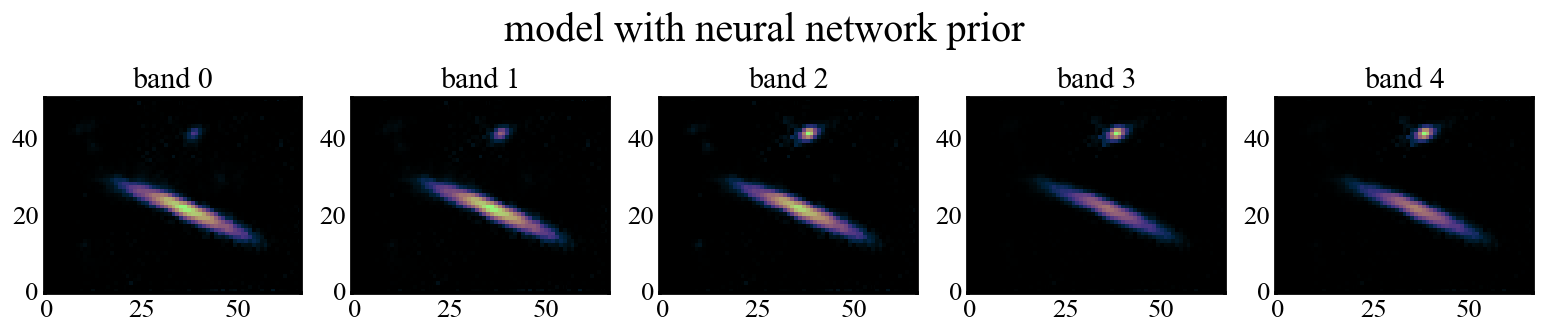

In [38]:
# create some plots to see how the sources look
sources = scene()
fig, axes = plt.subplots(1, sources.shape[0], figsize=(16,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(sources[i], cmap = cmap, vmin = 0,  interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model with neural network prior', fontsize=24,y=0.75)
plt.show()

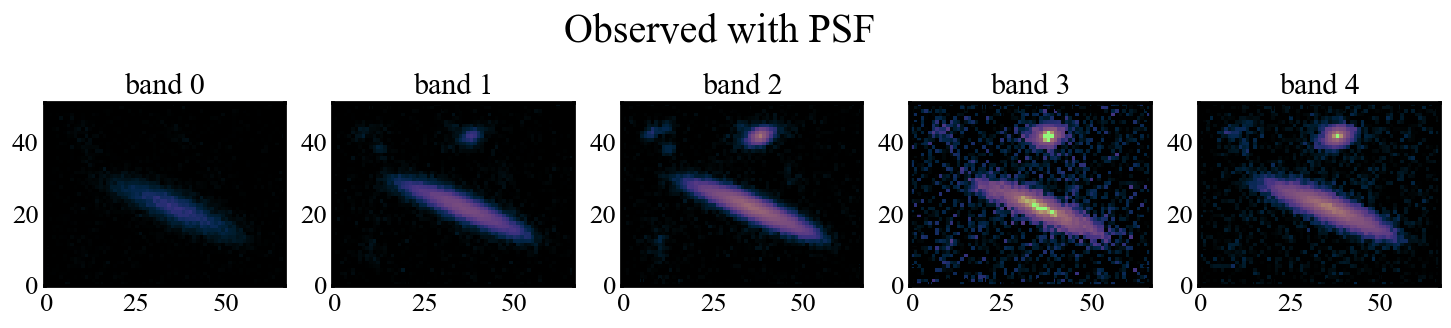

In [39]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    #ax.imshow(obs.data[i], cmap = cmap,vmin=0, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('Observed with PSF', fontsize=24,y=0.75)
plt.show()

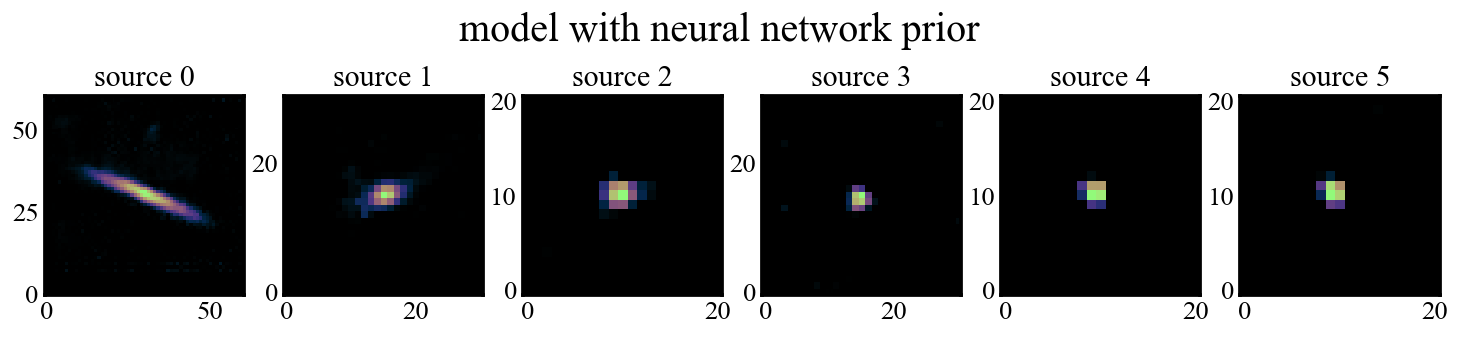

<Figure size 2000x1400 with 0 Axes>

In [40]:
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene.sources[i].morphology.value
    ax.imshow(y, cmap = cmap, vmin = 0,interpolation=int_method)
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model with neural network prior', fontsize=24,y=0.75)
#plt.suptitle('model no prior', fontsize=24,y=0.75)
plt.show()
plt.clf()

In [41]:
# observation model plus rendered
renders = obs.render(scene())

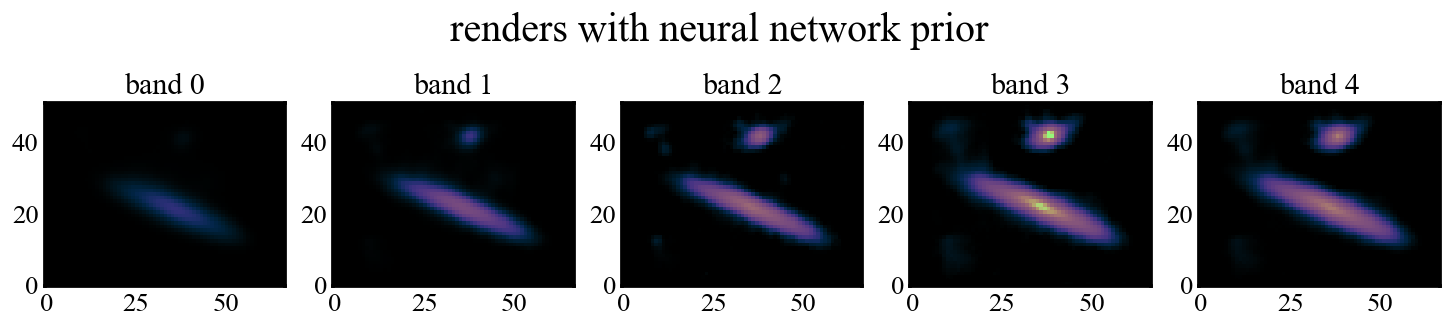

<Figure size 2000x1400 with 0 Axes>

In [42]:
fig, axes = plt.subplots(1, len( renders ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = renders[i]
    ax.imshow(y, cmap = cmap,norm=norm,interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('renders with neural network prior', fontsize=24,y=0.75)
#plt.suptitle('model no prior', fontsize=24,y=0.75)
plt.show()
plt.clf()

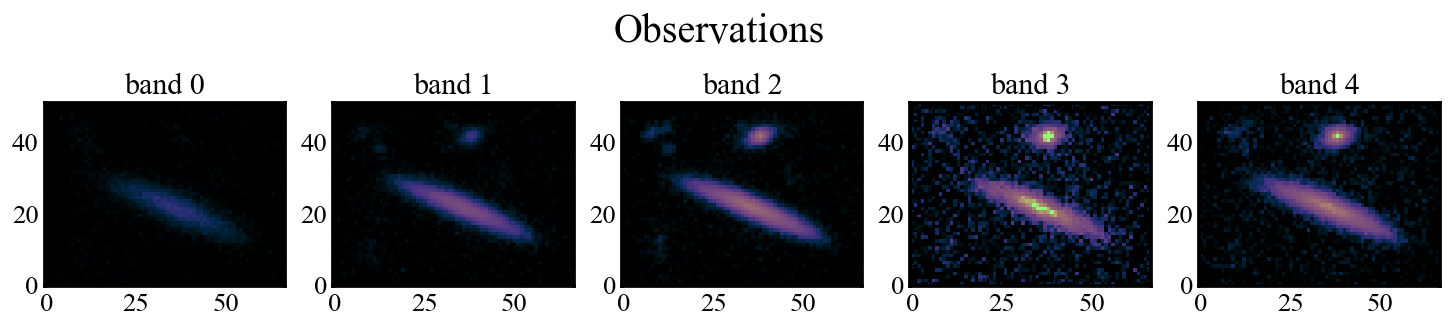

In [43]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('Observations', fontsize=24,y=0.75)
plt.show()

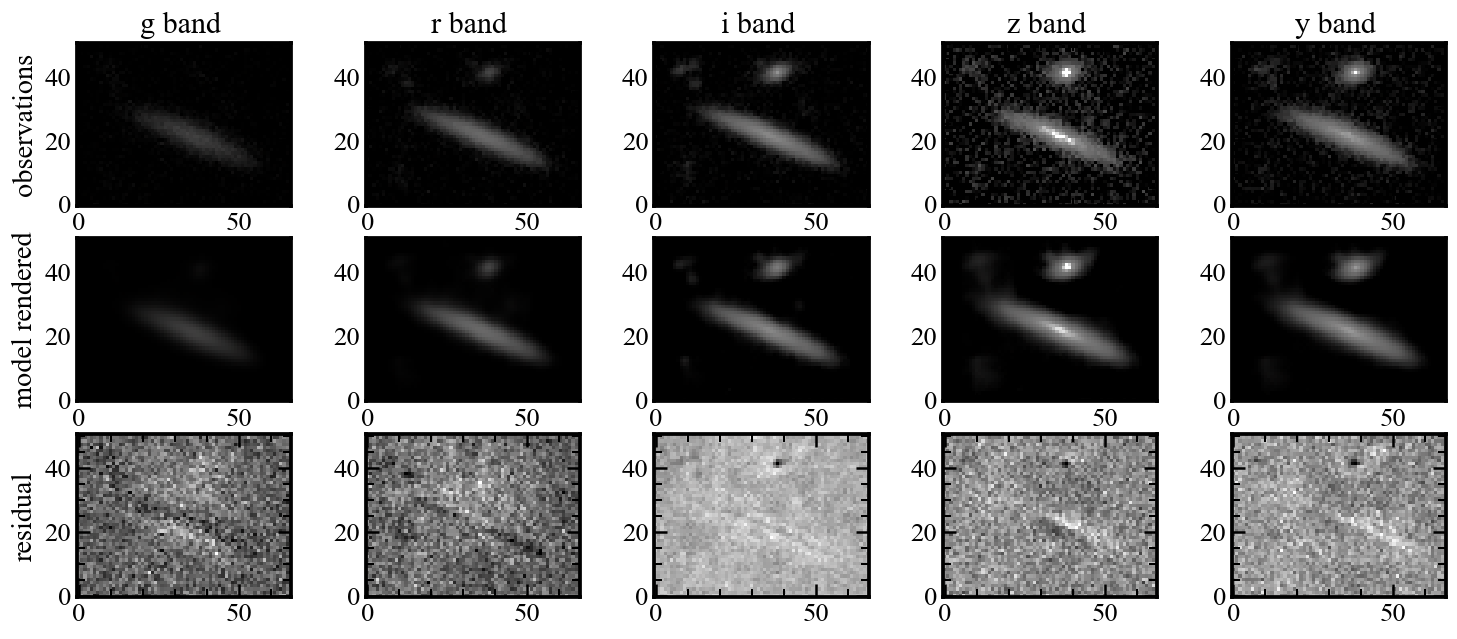

In [44]:
band_list = ['g', 'r', 'i', 'z', 'y']
cmap = cmr.neutral
fig, axes = plt.subplots(3, sources.shape[0], figsize=(15,6),dpi=120)
for idx in range(sources.shape[0]):
    axes[0][idx].imshow(obs.data[idx], cmap = cmap,norm=norm, interpolation=int_method)
    axes[0][idx].set_title(f"{band_list[idx]} band ", fontsize = 18)
    axes[0][idx].invert_yaxis()
    
    axes[1][idx].imshow(renders[idx], cmap = cmap,norm=norm, interpolation=int_method)
    #axes[1][idx].imshow(renders[idx], cmap = cmap, interpolation=int_method)
    axes[1][idx].invert_yaxis()
    
    axes[2][idx].imshow(renders[idx] - obs.data[idx], cmap = cmap, interpolation=int_method)
    axes[2][idx].invert_yaxis()
axes[0][0].set_ylabel("observations", fontsize = 17)
axes[1][0].set_ylabel("model rendered", fontsize = 17)
axes[2][0].set_ylabel("residual", fontsize = 17)
plt.savefig("renders.pdf", bbox_inches='tight')
plt.show()